In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

In [2]:
breast_cancer = pd.read_csv('Breast Cancer Wisconsin Diagnostic Data Set.csv')
breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


B    357
M    212
Name: diagnosis, dtype: int64


[Text(0,0,'Benign'), Text(0,0,'Malignant')]

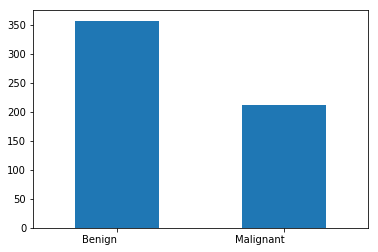

In [3]:
# Value counts for each class are not overly imbalanced

print(breast_cancer['diagnosis'].value_counts())
ax=plt.gca()
breast_cancer['diagnosis'].value_counts().plot(kind='bar');
ax.set_xticklabels(['Benign','Malignant'],ha='right',rotation=0)

In [4]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [5]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
breast_cancer_corr = breast_cancer.drop(columns = ['id', 'Unnamed: 32'])
breast_cancer_corr['diagnosis'] = lb.fit_transform(breast_cancer_corr['diagnosis'].values)
breast_cancer_corr = breast_cancer_corr.corr()
breast_cancer_corr['diagnosis'].sort_values(ascending=False)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

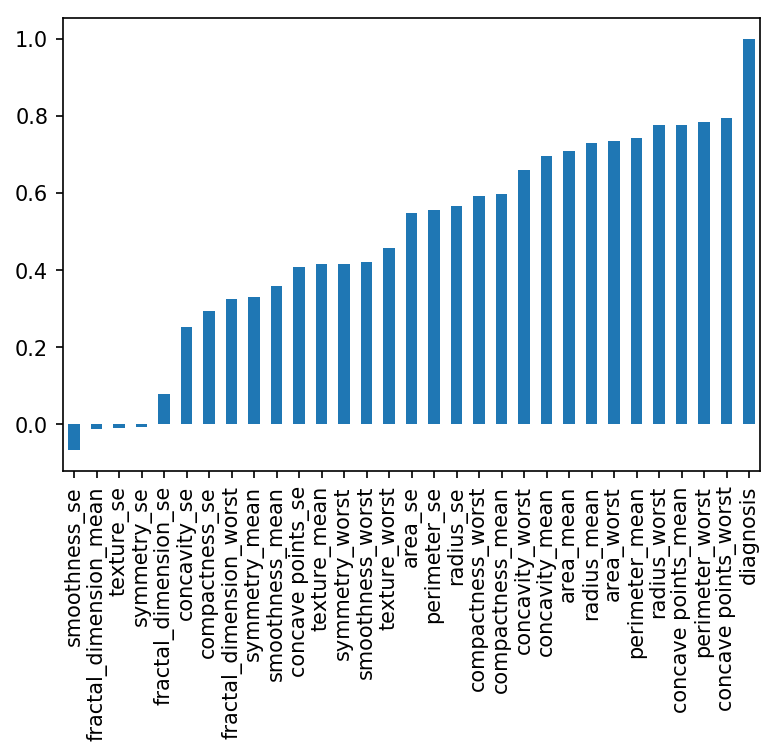

In [74]:
plt.figure(dpi=150)
breast_cancer_corr['diagnosis'].sort_values().plot(kind='bar',sort_columns=True);

In [7]:
# by default majority class (benign) will be negative

lb = LabelBinarizer()
breast_cancer['diagnosis'] = lb.fit_transform(breast_cancer['diagnosis'].values)
targets = breast_cancer['diagnosis']

breast_cancer.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(breast_cancer, targets, stratify=targets, random_state=42)

In [8]:
# Show the distribution

print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.626761
1    0.373239
Name: diagnosis, dtype: float64
y_test class distribution
0    0.629371
1    0.370629
Name: diagnosis, dtype: float64


In [48]:
classification_models = {
    'KNN Classifier': KNeighborsClassifier(),
    'Logistic Regression Classifier': LogisticRegression(),
    'GaussianNB Naive Bayes': GaussianNB(), 
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42), 
    'Extreme Gradient Boosting Classifier': XGBClassifier(random_state=42), 
    'Support Vector Classifier': SVC()
}

hyperparameter_grid = {
    'KNN Classifier': {'n_neighbors': list(range(1, 101)), 'p' : [1, 2, 3, 4, 5]},
    'Logistic Regression Classifier': {'penalty' : ['l1', 'l2'], 
                                       'C' : np.linspace(1e-10, 1, 11), 'solver' : ['liblinear']},
    'GaussianNB Naive Bayes': {'var_smoothing': np.linspace(1e-10, 1, 11)},
    'Random Forest Classifier': {'max_depth': list(range(1, 101)), 'n_estimators': list(range(1,101))}, 
    'Gradient Boosting Classifier': {'max_depth':list(range(1, 101)), 
                                     'learning_rate': np.linspace(1e-10, 1, 11), 
                                     'n_estimators': [5, 10, 25, 50, 100]},
    'Extreme Gradient Boosting Classifier': {'max_depth': list(range(1, 101)), 
                                             'learning_rate': np.linspace(1e-10, 1, 11), 
                                             'n_estimators': [5, 10, 25, 50, 100]}, 
    'Support Vector Classifier': {'kernel':['rbf', 'poly'], 'C': list(range(1,10)), 
                                  'gamma': np.linspace(1e-10, 1, 11)}
}


In [49]:
def hyperparameter_grid_search(X, y, models, hyperparameter_grid, scoring):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_model_params = []
    
    for model, params in list(zip(models.values(), hyperparameter_grid.values())):
        rand = RandomizedSearchCV(model, params, cv=5, scoring=scoring, random_state=42)
        rand.fit(X_train_scaled, y_train)
        best_model_params.append([model, rand.best_params_,  rand.best_score_])
        
    return best_model_params

In [50]:
import warnings
warnings.filterwarnings('ignore')

hyperparameter_grid_search(breast_cancer, targets, classification_models, hyperparameter_grid, scoring='recall')

[[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                       weights='uniform'),
  {'p': 4, 'n_neighbors': 15},
  0.9052594464359172],
 [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.20000000008000002},
  0.9644825762472821],
 [GaussianNB(priors=None, var_smoothing=1e-09),
  {'var_smoothing': 1e-10},
  0.8933008168302286],
 [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurit

In [66]:
# Create X matrix and y vector from columns 

X = breast_cancer
y = targets
print(X.shape, y.shape)

# Standard Scaling

std_scale = StandardScaler()
X = std_scale.fit_transform(X)

# Train, Test, Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(569, 30) (569,)


In [68]:
# The tuned logistic regression classifier performed best of all models

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit on train
lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.2)
lr.fit(X_train, y_train)

# Test on test
y_pred = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)
print('Logistic Regression Accuracy: {}'.format(lr_accuracy))
print('Logistic Regression Precision: {}'.format(lr_precision))
print('Logistic Regression Recall: {}'.format(lr_recall))

Logistic Regression Accuracy: 0.9649122807017544
Logistic Regression Precision: 0.9534883720930233
Logistic Regression Recall: 0.9534883720930233


In [69]:
lr.fit(X_train, y_train)
lr_confusion = confusion_matrix(y_test, lr.predict(X_test))
lr_confusion

array([[69,  2],
       [ 2, 41]])

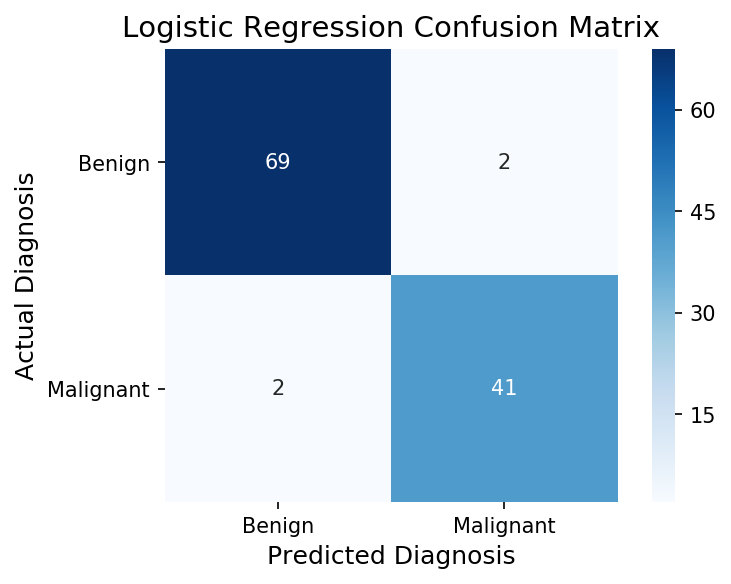

In [70]:
# Print confusion matrix for kNN
lr_confusion = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(dpi=150)
cm = sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd', 
                 xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
cm.set_yticklabels(labels = ['Benign', 'Malignant'], rotation=0)

plt.xlabel('Predicted Diagnosis', fontsize=12)
plt.ylabel('Actual Diagnosis', fontsize=12)
plt.title('Logistic Regression Confusion Matrix', fontsize=14);

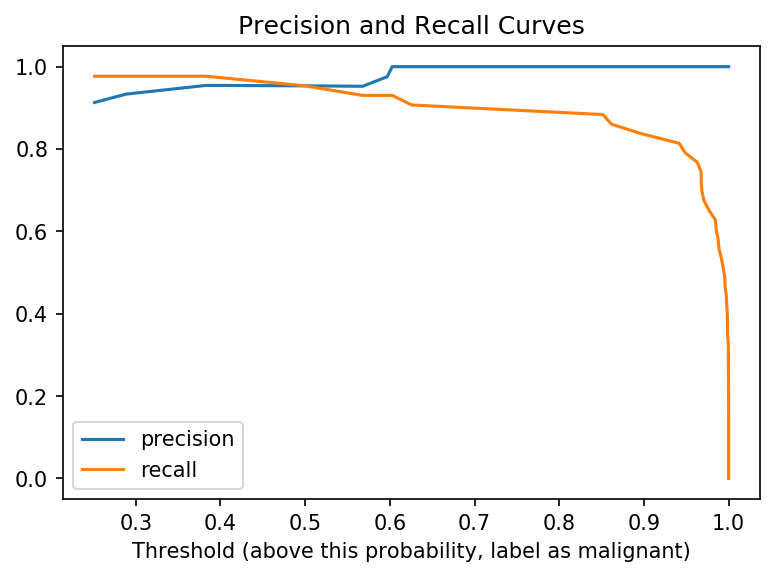

In [73]:
# We can also use the probabilities to make a curve showing us how recall and thresholds trade off 

y_scores = lr.predict_proba(X_test)[:, 1]
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(dpi=150)
plt.plot(lr_thresholds, lr_precision[1:],label='precision')
plt.plot(lr_thresholds, lr_recall[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as malignant)');
plt.title('Precision and Recall Curves');

In [75]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(model, p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_scores = model.predict_proba(X_test)[:,1]
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(dpi=150);
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=15)

     pred_neg  pred_pos
neg        69         2
pos         2        41


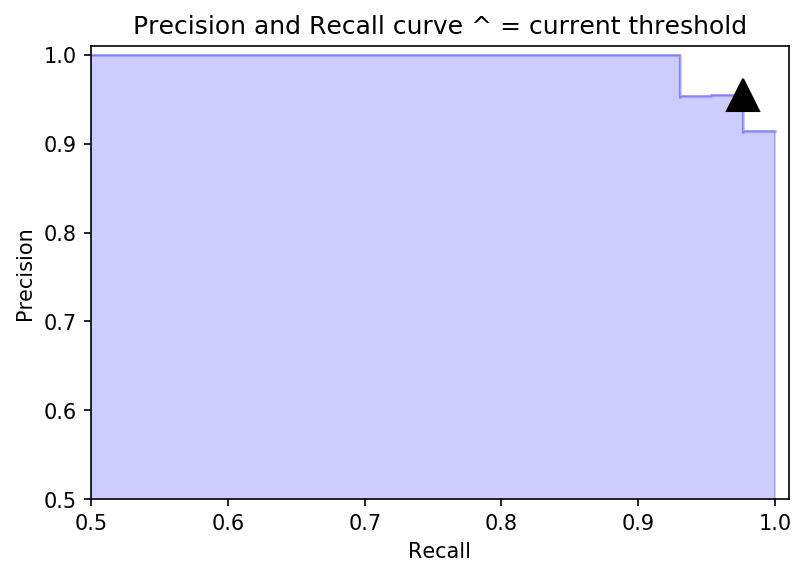

In [76]:
precision_recall_threshold(lr, lr_precision, lr_recall, lr_thresholds, 0.5)

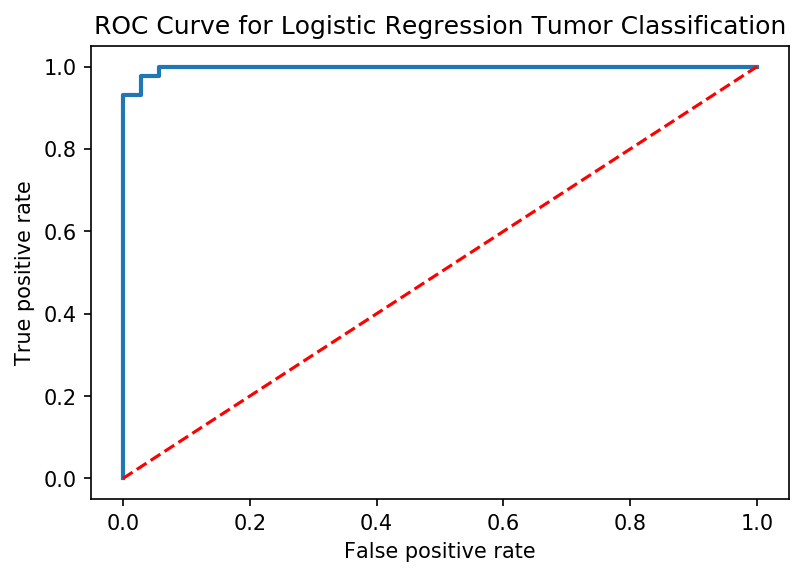

In [129]:
# Visualize the ROC curve for the logistic regression classifier

lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_scores)

plt.figure(dpi=150);
plt.plot(lr_fpr, lr_tpr,lw=2)
plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', size=10)
plt.ylabel('True positive rate', size=10)
plt.title('ROC Curve for Logistic Regression Tumor Classification', size=12);

In [111]:
# Let's evaluate feature importance and see which feature coefficients were zeroed out

feature_list = []
coef_list = []

for feature in breast_cancer.columns:
    feature_list.append(feature)

for i in lr.coef_:
    for coef in i:
        coef_list.append(coef)
        
lr_feature_coefs = dict()
        
for i,x in zip(feature_list, coef_list):
    lr_feature_coefs.update({i: x}) 
    
lr_feature_coefs = [(k, lr_feature_coefs[k]) for k in sorted(lr_feature_coefs, key=lr_feature_coefs.get, reverse=True)]
lr_feature_coefs

[('radius_worst', 2.727964233996332),
 ('concave points_mean', 1.0541607231624355),
 ('texture_worst', 0.9901933218750868),
 ('radius_se', 0.8150930256472947),
 ('smoothness_worst', 0.381596135195524),
 ('symmetry_worst', 0.3497967904801756),
 ('concavity_worst', 0.31844392139709654),
 ('concave points_worst', 0.3114047583131171),
 ('radius_mean', 0.0),
 ('texture_mean', 0.0),
 ('perimeter_mean', 0.0),
 ('area_mean', 0.0),
 ('smoothness_mean', 0.0),
 ('compactness_mean', 0.0),
 ('concavity_mean', 0.0),
 ('symmetry_mean', 0.0),
 ('fractal_dimension_mean', 0.0),
 ('texture_se', 0.0),
 ('perimeter_se', 0.0),
 ('area_se', 0.0),
 ('smoothness_se', 0.0),
 ('compactness_se', 0.0),
 ('concavity_se', 0.0),
 ('concave points_se', 0.0),
 ('symmetry_se', 0.0),
 ('perimeter_worst', 0.0),
 ('area_worst', 0.0),
 ('compactness_worst', 0.0),
 ('fractal_dimension_worst', 0.0),
 ('fractal_dimension_se', -0.10578131996135495)]

In [117]:
# Evaluate features with nonzero coefficients

lr_nonzero_coefs = dict()

for i,x in zip(feature_list, coef_list):
    if x:
        lr_nonzero_coefs.update({i: x}) 
    
lr_nonzero_coefs = [(k, lr_nonzero_coefs[k]) for k in sorted(lr_nonzero_coefs, key=lr_nonzero_coefs.get, reverse=True)]
print('Total Nonzero Coefficients: {}'.format(len(lr_nonzero_coefs)))
lr_nonzero_coefs

Total Nonzero Coefficients: 9


[('radius_worst', 2.727964233996332),
 ('concave points_mean', 1.0541607231624355),
 ('texture_worst', 0.9901933218750868),
 ('radius_se', 0.8150930256472947),
 ('smoothness_worst', 0.381596135195524),
 ('symmetry_worst', 0.3497967904801756),
 ('concavity_worst', 0.31844392139709654),
 ('concave points_worst', 0.3114047583131171),
 ('fractal_dimension_se', -0.10578131996135495)]

In [124]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# Read in the data again for visualization with plotly

Breast_Cancer = pd.read_csv('Breast Cancer Wisconsin Diagnostic Data Set.csv')
Breast_Cancer = Breast_Cancer.replace('B', 0)
Breast_Cancer = Breast_Cancer.replace('M', 1)
Breast_Cancer = Breast_Cancer.iloc[:, 1:-1]

# Select the three features with the largest coefficients from our logistic regression classifier

x = Breast_Cancer['radius_worst']
y = Breast_Cancer['concave points_mean']
z = Breast_Cancer['texture_worst']
c = Breast_Cancer['diagnosis']

# A quick definition for each feature:

# 1.  radius_worst  -  "worst" or largest mean value for mean of distances from center to points on the perimeter
# 2.  concave points_mean  -  mean for number of concave portions of the contour
# 3.  texture_worst  -  "worst" or largest mean value for standard deviation of gray-scale values

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
    size=3,
    color=c,
    colorscale=[[0.0, 'rgb(49,54,149)'], [1.0, 'rgb(165,0,38)']],
    opacity=0.25),
    showlegend=False)

data = [trace1]
layout = go.Layout(
    margin=dict(
    l=0,
    r=0, 
    b=0,
    t=0)
)

layout = go.Layout(
    scene = dict(
    xaxis = dict(
        title='radius_worst'),
    yaxis = dict(
        title='concave points_mean'),
    zaxis = dict(
        title='texture_worst'),),
    width=700,
    margin=dict(
    r=20, b=10,
    l=10, t=10)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-pubg-plot')
